# Import libraries

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2 as cv2
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Preprocessing

## Load images

In [2]:
# Define the path to the dataset directory
dataset_dir = 'C:\\FingerprintBiometric\\new_altered'

# Lists to store image data and labels
image_data = []
labels = []
# finger_labels = []
#person_labels = []


# Iterate through the dataset and load images and labels
for filename in os.listdir(dataset_dir):
    # Extract labels from the filename
    ids = filename.split('_')
    person_id = ids[0]
    hand_id = ids[3]
    finger_id = ids[4]
    # Load the image
    img_path = os.path.join(dataset_dir, filename)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        image_data.append(img)
        labels.append((person_id, hand_id, finger_id))
        # person_labels.append(person_id)

# Now 'image_data' contains the loaded images, and 'labels' contains the corresponding labels

In [3]:
print(image_data[0])

[[160 160 160 ...   0   0   0]
 [160 105 105 ...   0   0   0]
 [160 105 255 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


In [4]:
labels_array = np.array(labels)

# Extract individual components: person IDs, finger IDs, and scan numbers
person_ids = np.unique(labels_array[:, 0])
hand_ids = np.unique(labels_array[:, 1])
finger_ids = np.unique(labels_array[:, 2])

num_unique_persons = len(person_ids)
num_unique_hands = len(hand_ids)
num_unique_fingers = len(finger_ids)

print("Number of unique persons:", num_unique_persons)
print(person_ids)
print("Number of unique hands:", num_unique_hands)
print(hand_ids)
print("Number of unique fingers:", num_unique_fingers)
print(finger_ids)

print(labels_array)
print(len(labels_array))

Number of unique persons: 100
['10' '100' '101' '102' '103' '104' '105' '106' '107' '108' '109' '11'
 '110' '111' '112' '113' '114' '115' '116' '117' '118' '119' '12' '120'
 '121' '122' '123' '124' '125' '126' '127' '128' '129' '13' '130' '131'
 '132' '133' '134' '135' '136' '137' '138' '139' '14' '140' '141' '142'
 '143' '144' '145' '146' '147' '148' '149' '15' '150' '151' '152' '153'
 '154' '155' '156' '157' '158' '159' '16' '160' '161' '162' '163' '164'
 '165' '166' '167' '168' '169' '17' '170' '171' '172' '173' '174' '175'
 '176' '177' '178' '179' '18' '180' '181' '182' '183' '184' '185' '186'
 '187' '188' '189' '190']
Number of unique hands: 2
['Left' 'Right']
Number of unique fingers: 5
['index' 'little' 'middle' 'ring' 'thumb']
[['100' 'Left' 'index']
 ['100' 'Left' 'index']
 ['100' 'Left' 'index']
 ...
 ['190' 'Right' 'thumb']
 ['190' 'Right' 'thumb']
 ['190' 'Right' 'thumb']]
20000


## Data analysis

In [5]:
print(len(image_data))
print(len(labels))


20000
20000


In [6]:
# Convert the list of labels to a set to remove duplicates
unique_labels = set(labels)

# The length of the set is the number of unique labels
num_unique_labels = len(unique_labels)

print(f'There are {num_unique_labels} unique labels.')
print(num_unique_labels)

There are 1000 unique labels.
1000


{103: 20000}


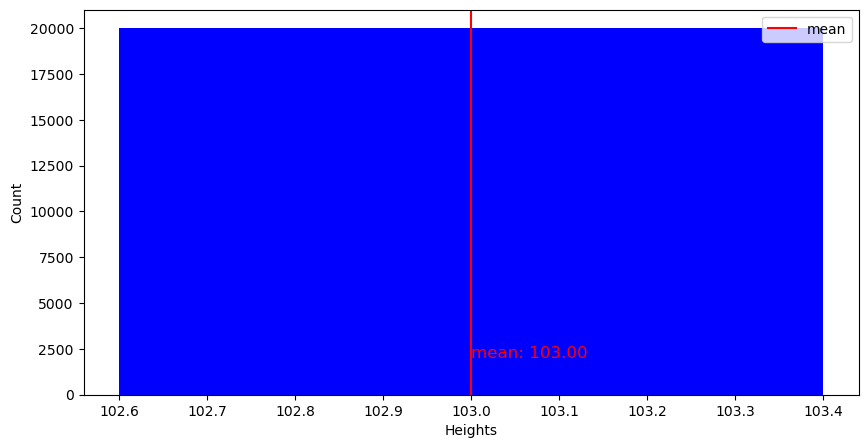

In [7]:
hist = {}
for image in image_data:
    height = image.shape[0]
    hist[height] = hist.get(height, 0) + 1

print(hist)

sum_height = 0
sum_num = 0

for height, num in hist.items():  # Use .items() to iterate over dictionary key-value pairs
    sum_height += height * num
    sum_num += num

mean = sum_height / sum_num

# Create a bar chart for the histogram
plt.figure(figsize=(10, 5))
plt.bar(list(hist.keys()), list(hist.values()), color="b")
plt.xlabel("Heights")
plt.ylabel("Count")

# Plot the mean value as a horizontal line
plt.axvline(x=mean, color='r', label='mean')
plt.text(mean, 2000, f'mean: {mean:.2f}', fontsize=12, color='r')

plt.legend()  # Add a legend to the plot

plt.show()

{96: 20000}


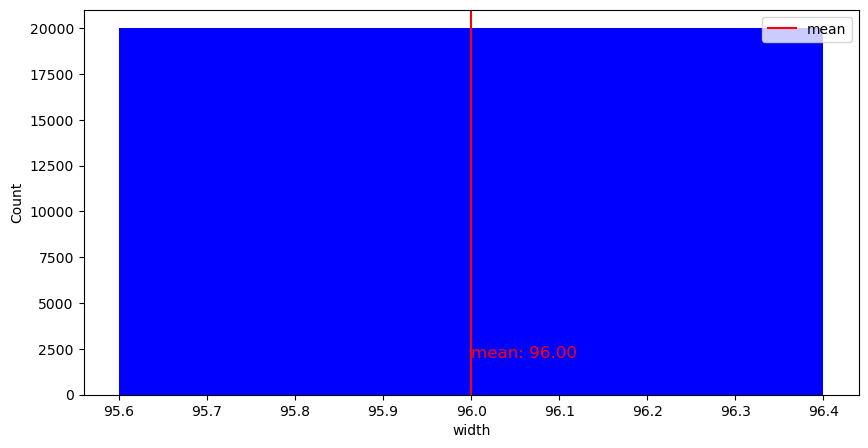

In [8]:
hist = {}
for image in image_data:
    width = image.shape[1]
    hist[width] = hist.get(width, 0) + 1

print(hist)

sum_width = 0
sum_num = 0

for width, num in hist.items():  # Use .items() to iterate over dictionary key-value pairs
    sum_width += width * num
    sum_num += num

mean = sum_width / sum_num

# Create a bar chart for the histogram
plt.figure(figsize=(10, 5))
plt.bar(list(hist.keys()), list(hist.values()), color="b")
plt.xlabel("width")
plt.ylabel("Count")

# Plot the mean value as a horizontal line
plt.axvline(x=mean, color='r', label='mean')
plt.text(mean, 2000, f'mean: {mean:.2f}', fontsize=12, color='r')

plt.legend()  # Add a legend to the plot

plt.show()

Most of the images have fixed size (96, 103) -> Therefore we resize all images to 96 x 103

In [9]:
# resizing all the data to 103X96
for i,image in enumerate(image_data):
    image_data[i] = cv2.resize(image ,(96,103))

## Histogram equalization

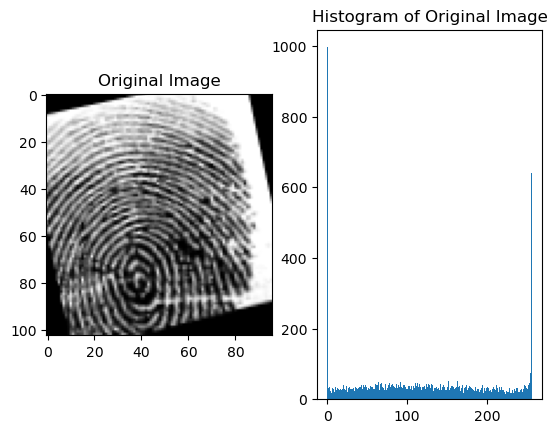

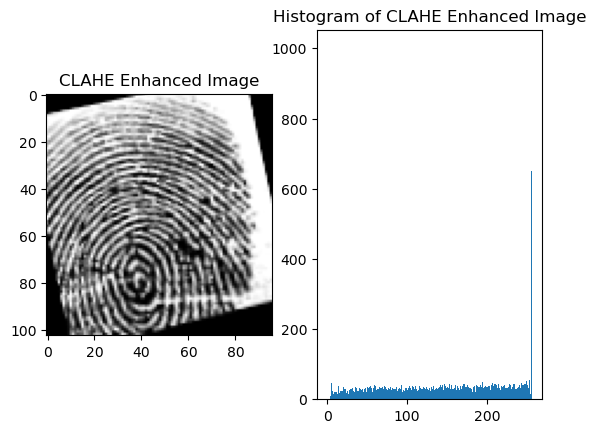

In [10]:
plt.figure()

# Assuming data is your set of images
real_img = image_data[77]  # Change index according to your dataset

# Plot original image and its histogram
plt.subplot(121)
plt.imshow(real_img, cmap='gray')
plt.title('Original Image')

plt.subplot(122)
plt.hist(real_img.ravel(), 256, [0, 256])
plt.title('Histogram of Original Image')

plt.show()

# Apply CLAHE to all images in the 'data' set
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
for i in range(len(image_data)):
    new = clahe.apply(image_data[i])
    image_data[i] = new

# Display the results after CLAHE
plt.figure()

# Plot CLAHE-enhanced image and its histogram for the same index
plt.subplot(121)
plt.imshow(image_data[77], cmap='gray')
plt.title('CLAHE Enhanced Image')

plt.subplot(122)
plt.hist(image_data[77].ravel(), 256, [0, 256])
plt.title('Histogram of CLAHE Enhanced Image')

plt.show()

# Model

## SVM

### HOG feature extraction

In [14]:
# Initialize HOG descriptor
hog = cv2.HOGDescriptor()

# Extract features using HOG for each image
hog_features = []
for img in image_data:
    hog_img = cv2.resize(img, (64, 128), interpolation=cv2.INTER_AREA)  # Resize image to a common size for HOG
    features = hog.compute(hog_img)
    hog_features.append(features.flatten())

# Now 'hog_features' contains the extracted HOG features


### Label encoding

In [124]:
# Convert the tuples to strings
string_labels = ['_'.join(map(str, label)) for label in labels]

# Instantiate the LabelEncoder
label_encoder = LabelEncoder()

# Use fit_transform to transform the combined labels into encoded integers
encoded_labels = label_encoder.fit_transform(string_labels)

# Get the counts of each label
label_counts = np.bincount(encoded_labels)

# Print the count of each label
#for label, count in enumerate(label_counts):
 #   print(f"Label {label}: {count} instances")
print(encoded_labels)

[100 101 102 103 104 105 106 107 108 109   0   1   2   3   4   5   6   7
   8   9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25
  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43
  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61
  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79
  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97
  98  99 210 211 212 213 214 215 216 217 218 219 110 111 112 113 114 115
 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133
 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151
 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169
 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187
 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205
 206 207 208 209 320 321 322 323 324 325 326 327 328 329 220 221 222 223
 224 225 226 227 228 229 230 231 232 233 234 235 23

In [11]:
features = hog_features  

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, encoded_labels, test_size=0.2, random_state=42, stratify=encoded_labels)

In [14]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

# Define the parameter grid without 'gamma'
param_grid = {'C': np.arange(0.9, 1.1, 0.1), # np.arange(0.05, 1.05, 0.05)
              'gamma': [0.1, 0.01], # [1, 0.1, 0.01, 0.001]
              'kernel': ['linear']} #'kernel': ['rbf', 'sigmoid', 'linear', 'poly']

# Initialize the SVM classifier
svm = SVC(class_weight='balanced')

# Initialize Stratified K-fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize GridSearchCV with Stratified K-fold
# scoring ở đây nên để là recall/f1 tuy nhiên code lại bị lỗi nếu để thế, ae nghiên cứu fix hộ
# n_jobs = -1 sẽ dùng full cpu, nếu muốn chỉ dùng 2 core, để n_jobs=2
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=skf, n_jobs=3, scoring='accuracy')

# Fit the data to perform grid search
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

In [ ]:
# Train the SVM model with the best parameters
best_svm = SVC(**best_params)
best_svm.fit(X_train, y_train)

# Predict on the test set
y_pred = best_svm.predict(X_test)

print(classification_report(y_test,y_pred))

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# CNN


In [11]:
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

image_data = np.array(image_data)
# Convert 2d array to 1d array
labels_array_1d = ['_'.join(row) for row in labels_array]

le = LabelEncoder()
labels_encoded = le.fit_transform(labels_array_1d)
labels_one_hot = to_categorical(labels_encoded)

# Normalize image data to 0-1 range
image_data = image_data / 255.0




In [12]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(image_data, labels_one_hot, test_size=0.2, random_state=42, stratify= labels_one_hot)

In [13]:
X_train = X_train.reshape(-1, 96, 103, 1)
X_test = X_test.reshape(-1, 96, 103, 1)


In [14]:
print(image_data[0])
print(labels_one_hot)

[[0.96470588 0.96470588 0.96470588 ... 0.01176471 0.01176471 0.01176471]
 [0.96470588 0.63137255 0.63137255 ... 0.01176471 0.01176471 0.01176471]
 [0.96470588 0.63137255 1.         ... 0.01176471 0.01176471 0.01176471]
 ...
 [0.01176471 0.01176471 0.01176471 ... 0.01176471 0.01176471 0.01176471]
 [0.01176471 0.01176471 0.01176471 ... 0.01176471 0.01176471 0.01176471]
 [0.01176471 0.01176471 0.01176471 ... 0.01176471 0.01176471 0.01176471]]
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [ ]:
#hyperparameters tuning
import keras_tuner
import keras
from kerastuner.tuners import RandomSearch

def model_building(hp):
    model = Sequential()
    model.add(Conv2D(
        filters = hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
        kernel_size = 3,
        activation = 'relu',
        input_shape = (96,103,1)
    ))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(
        filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
        kernel_size = 3,
        activation='relu'
    ))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
        activation='relu'
    ))
    model.add(Dense(1000, activation='softmax'))
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model

tuner = RandomSearch(
    model_building,
    objective='val_accuracy',
    max_trials=5,
    directory='output',
    project_name="FingerprintRecognition",
    
)

tuner.search(X_train, y_train, epochs=3, validation_data=(X_test, y_test))


In [16]:
import tensorflow as tf

num_cores = 3

# Set up TensorFlow configuration
config = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=num_cores,
    inter_op_parallelism_threads=num_cores,
    allow_soft_placement=True,
    device_count={'CPU': num_cores}
)

# Create a TensorFlow session with the specified configuration
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print(f"The optimal number of units in the first densely-connected layer is {best_hps.get('dense_1_units')}")
print(f"The optimal number of filters in the first conv layer is {best_hps.get('conv_1_filter')}")
print(f"The optimal number of filters in the second conv layer is {best_hps.get('conv_2_filter')}")
print(f"The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}")


# Build the model with the optimal hyperparameters
model = tuner.hypermodel.build(best_hps)

# Train the model on the data
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))



The optimal number of units in the first densely-connected layer is 80
The optimal number of filters in the first conv layer is 32
The optimal number of filters in the second conv layer is 48
The optimal learning rate for the optimizer is 0.001
Epoch 1/50
500/500 [==============================] - 116s 231ms/step - loss: 6.7395 - accuracy: 0.0036 - val_loss: 6.0702 - val_accuracy: 0.0235
Epoch 2/50
500/500 [==============================] - 110s 220ms/step - loss: 4.3219 - accuracy: 0.1398 - val_loss: 2.6571 - val_accuracy: 0.3315
Epoch 3/50
500/500 [==============================] - 108s 217ms/step - loss: 1.8804 - accuracy: 0.4914 - val_loss: 1.5095 - val_accuracy: 0.5863
Epoch 4/50
500/500 [==============================] - 109s 217ms/step - loss: 0.9894 - accuracy: 0.7110 - val_loss: 1.0547 - val_accuracy: 0.6923
Epoch 5/50
500/500 [==============================] - 107s 214ms/step - loss: 0.6102 - accuracy: 0.8139 - val_loss: 1.0307 - val_accuracy: 0.7195
Epoch 6/50
500/500 [====

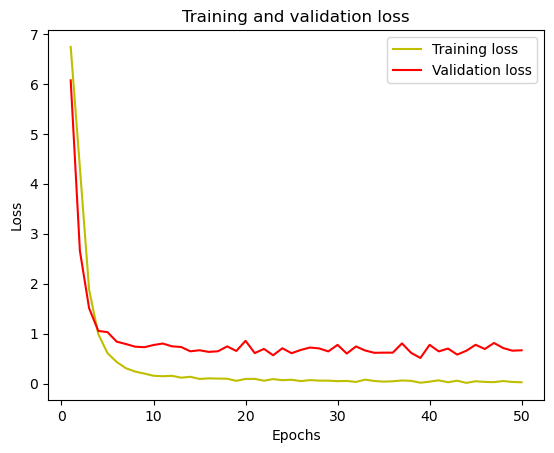

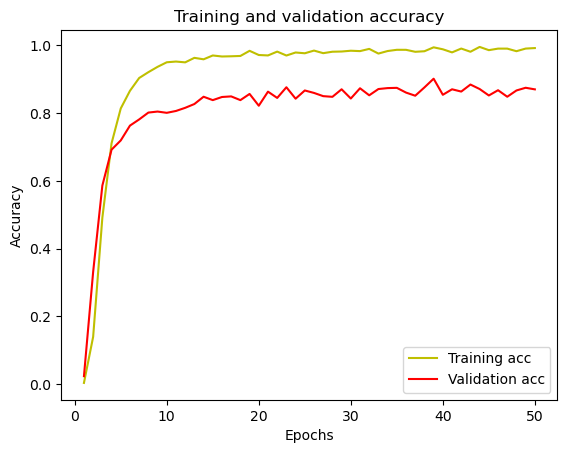

In [17]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(epochs, accuracy, 'y', label='Training acc')
plt.plot(epochs, val_accuracy, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()